# Deep Latent Policy Gradient for Ant

In [1]:
import gym,warnings,time
warnings.filterwarnings("ignore") # Stop annoying warnings
gym.logger.set_level(40)
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline
import skvideo.io
from datetime import datetime
from custom_ant import AntEnvCustom # Custom ant 
from lgrp_class import lgrp_class # Gaussian random path
from vae_class import vae_class # VAE
from antTrainEnv_class import antTrainEnv_class
from util import PID_class,display_frames_as_gif,\
    quaternion_to_euler_angle,multi_dim_interp,cpu_sess,gpu_sess,Scaler
print ("TF version is [%s]."%(tf.__version__))

TF version is [1.8.0].


### Tuning parameters

In [2]:
nAnchor = 15
nIter4update = 1e2
maxEpoch  = 1000
batchSize = 50
nPrevConsider = 20
nPrevBestQ2Add = 50
name = 'ant_dlpg_nAnchor%d_nIter4update%d_batchSize%d'%\
    (nAnchor,nIter4update,batchSize)
print (name)

ant_dlpg_nAnchor15_nIter4update100_batchSize50


### Instantiate Class

Text name: results/ant_dlpg_nAnchor15_nIter4update100_batchSize50.txt
Custom Ant Environment made by SJ.


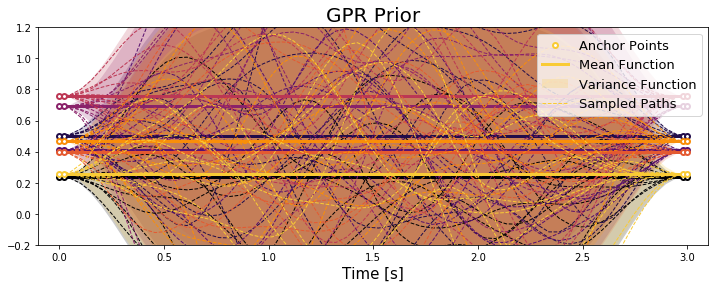

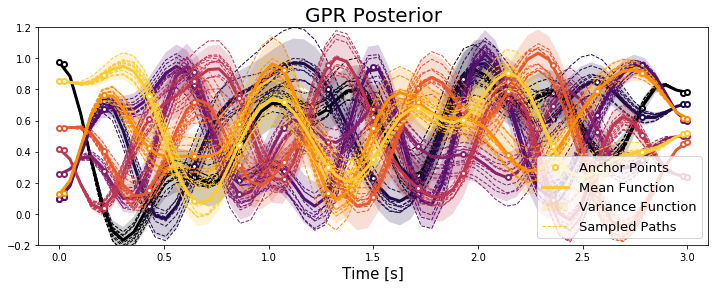

In [3]:
tf.reset_default_graph() # Reset Graph
AntEnv = antTrainEnv_class(_name=name,_tMax=3,_nAnchor=nAnchor,_maxRepeat=3,
                           _hypGainPrior=1/2,_hypLenPrior=1/2,
                           _hypGainPost=1/2,_hypLenPost=1/2,
                           _levBtw=0.9,_pGain=0.01,
                           _zDim=32,_hDims=[128,64],_vaeActv=tf.nn.relu,_vaeOutActv=None,_vaeQactv=tf.nn.tanh,
                           _PLOT_GRP=True,_SAVE_TXT=True)

### Train Ant

In [4]:
SAVE_VID = True
MAKE_GIF = False # Probably unnecessary 
PLOT_GRP = True 
PLOT_EVERY = 10

Start training...
[0/1000](#total:50) avgQ:[-45.727] XdispMean:[-0.027] XdispVar:[0.792] absHdispMean:[60.2] priorProb:[0.90]
 rSum:[-45.727] = (contact:-0.502+ctrl:-185.395+fwd:-1.322+heading:-38.507+survive:180.000) [rSumMax:122.177]
Creating window glfw
    [GRP mean] sumRwd:44.001=cntct:-0.29+ctrl:-133.58+fwd:13.71+hd:-15.84+srv:180.00) xD:[0.692] hD:[30.0]
     Video [vids/ant_dlpg_epoch000.mp4] saved.


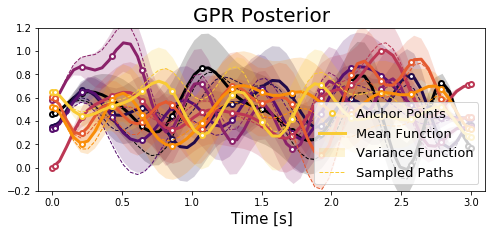

    [GRP-0] sumRwd:-165.948=cntct:-0.26+ctrl:-101.02+fwd:10.25+hd:-254.91+srv:180.00) xD:[0.742] hD:[87.8]


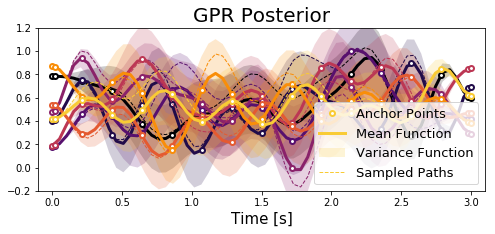

    [GRP-1] sumRwd:-114.417=cntct:-0.26+ctrl:-118.76+fwd:-34.83+hd:-140.56+srv:180.00) xD:[-1.542] hD:[-165.1]


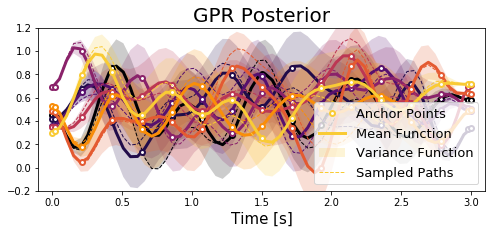

    [GRP-2] sumRwd:25.347=cntct:-0.12+ctrl:-45.48+fwd:-26.98+hd:-5.07+srv:103.00) xD:[-1.212] hD:[-9.4]
[1/1000](#total:100) avgQ:[-50.370] XdispMean:[-0.064] XdispVar:[0.727] absHdispMean:[59.2] priorProb:[0.90]
 rSum:[-50.370] = (contact:-0.493+ctrl:-186.024+fwd:-2.114+heading:-41.739+survive:180.000) [rSumMax:103.609]
[2/1000](#total:150) avgQ:[-48.520] XdispMean:[0.048] XdispVar:[0.769] absHdispMean:[68.6] priorProb:[0.90]
 rSum:[-48.520] = (contact:-0.490+ctrl:-179.267+fwd:0.194+heading:-46.797+survive:177.840) [rSumMax:103.857]
[3/1000](#total:200) avgQ:[-33.394] XdispMean:[0.013] XdispVar:[1.752] absHdispMean:[60.3] priorProb:[0.90]
 rSum:[-33.394] = (contact:-0.478+ctrl:-171.230+fwd:-0.790+heading:-40.896+survive:180.000) [rSumMax:133.536]
[4/1000](#total:250) avgQ:[-38.237] XdispMean:[0.151] XdispVar:[0.653] absHdispMean:[66.6] priorProb:[0.90]
 rSum:[-38.237] = (contact:-0.477+ctrl:-170.290+fwd:2.207+heading:-49.677+survive:180.000) [rSumMax:99.433]
[5/1000](#total:300) avgQ:

In [ ]:
sess = gpu_sess()
print ("Start training...")
AntEnv.train_dlpg(_sess=sess,_seed=0,_maxEpoch=maxEpoch,_batchSize=batchSize,_nIter4update=nIter4update,
                  _nPrevConsider=nPrevConsider,_nPrevBestQ2Add=nPrevBestQ2Add,
                  _SAVE_VID=SAVE_VID,_MAKE_GIF=MAKE_GIF,_PLOT_GRP=PLOT_GRP,_PLOT_EVERY=PLOT_EVERY,
                  _DO_RENDER=(SAVE_VID|MAKE_GIF))

### Make Final vid

In [ ]:
SAVE_VID_FINAL = False
MAKE_GIF_FINAL = False
PLOT_GRP_FINAL = True

In [ ]:
for _i in range(3):
    np.random.seed(seed=_i+100)
    sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
    sampledX = (sampledX-sampledX.min())/(sampledX.max()-sampledX.min())
    AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.99)
    avgRwd,ret = AntEnv.unit_rollout_from_grp_mean(_maxRepeat=AntEnv.maxRepeat,_DO_RENDER=True)
    print ("  [^] avgRwd:[%.3f] Xdisp:[%.3f] Hdisp:[%.3f]"%(avgRwd,ret['xDisp'],ret['hDisp']))
    if SAVE_VID_FINAL:
        outputdata = np.asarray(ret['frames']).astype(np.uint8)
        vidName = 'vids/ant_dlpg_final_%d.mp4'%(_i)
        skvideo.io.vwrite(vidName,outputdata)
        print ("[%s] saved."%(vidName))
    if MAKE_GIF_FINAL:
        display_frames_as_gif(ret['frames'],_intv_ms=20,_figsize=(6,6),_fontsize=15,
                              _titleStrs=ret['titleStrs'])
    if PLOT_GRP_FINAL:
        AntEnv.GRPposterior.plot_all(_nPath=10,_figsize=(10,4))